In [2]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image



In [8]:

# Define path inicial
initial_path = 'dog-breeds'

# Define nome dos diretorios
directories = ['train', 'val', 'test']

#deleta pastas caso existam
def delete_folder(path):
    try:
        shutil.rmtree(path)  
        #print(f"A pasta '{path}' foi deletada com sucesso.")
        next
    except FileNotFoundError:
        #print(f"O caminho especificado '{path}' não foi encontrado.")
        next
    except OSError as e:
        #print(f"Erro ao deletar a pasta '{path}': {e}")
        next


# Define subdiretorio de raças por ordem alfabetica
subdirectories = [subdirectory for subdirectory in os.listdir(initial_path) if os.path.isdir(os.path.join(initial_path, subdirectory))]

# Define as proporções para conjuntos de treinamento, validação e teste
props = [0.7, 0.2, 0.1]

# Função para verificar a relação entre altura e largura da imagem
def verificar_proporcao(imagem):
    largura, altura = imagem.size
    proporcao = altura / largura
    return 0.45 < proporcao < 1.7

# Loop sobre os diretórios de primeiro nível e subdiretórios, e criar os diretórios correspondentes
for directory in directories:
    delete_folder(directory)
    
    for subdirectory in subdirectories:
        path = os.path.join(initial_path, subdirectory)
        files = os.listdir(path)
        random.shuffle(files)
        total = len(files)
        train_end = int(total * props[0])
        val_end = train_end + int(total * props[1])
        if directory == 'train':
            new_files = files[:train_end]
        elif directory == 'val':
            new_files = files[train_end:val_end]
        else:
            new_files = files[val_end:]
        new_path = os.path.join(directory, subdirectory)
        os.makedirs(new_path, exist_ok=True)
        for file in new_files:
            old_file_path = os.path.join(path, file)
            new_file_path = os.path.join(new_path, file)
            try:
                with Image.open(old_file_path) as img:
                    if verificar_proporcao(img):
                        shutil.copy(old_file_path, new_file_path)
                    else:
                        #print(f"Ignorando {old_file_path}: Proporção não está dentro do intervalo desejado")
                        next
            except Exception as e:
                print(f"Erro ao processar {old_file_path}: {e}")


In [9]:
train_dir = 'train'
val_dir = 'val'

img_height = 224
img_width = 224
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 611 images belonging to 15 classes.
Found 173 images belonging to 15 classes.


In [10]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
class_num = len(subdirectories)
predictions = Dense(class_num, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
num_epochs = 8
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/8


c:\Users\lennon.silva\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.4661 - loss: 7.6641 - val_accuracy: 0.8562 - val_loss: 2.8233
Epoch 2/8
 1/19 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6875 - loss: 7.9738

c:\Users\lennon.silva\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6875 - loss: 7.9738 - val_accuracy: 0.9231 - val_loss: 0.3130
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.8431 - loss: 2.1323 - val_accuracy: 0.9688 - val_loss: 0.2276
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.8750 - loss: 0.5669 - val_accuracy: 1.0000 - val_loss: 4.7945e-05
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.8615 - loss: 1.2590 - val_accuracy: 0.9375 - val_loss: 0.1927
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9375 - loss: 0.3768 - val_accuracy: 0.9231 - val_loss: 0.0989
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8898 - loss: 0.9508 - val_accuracy: 0.9312 - val_loss: 0.2553
Epoch 8/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8438 - loss: 1.7032 - val_accuracy: 1.0000 - val_loss: 2.0971e-04


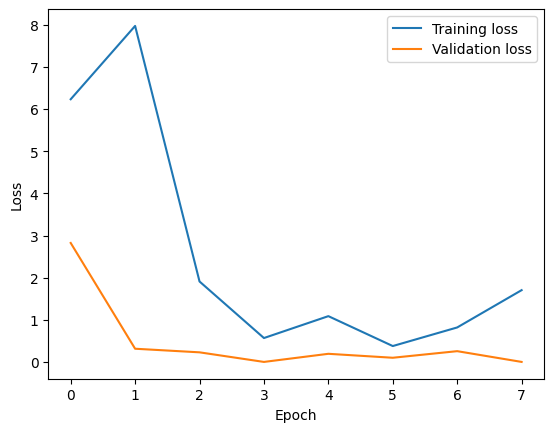

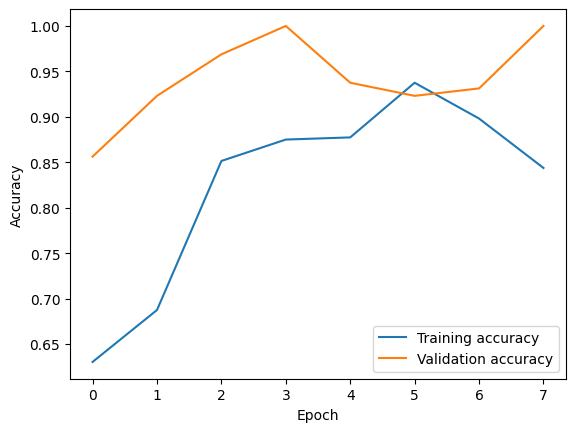

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

test_dir = "test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=1,  
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 101 images belonging to 15 classes.
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step


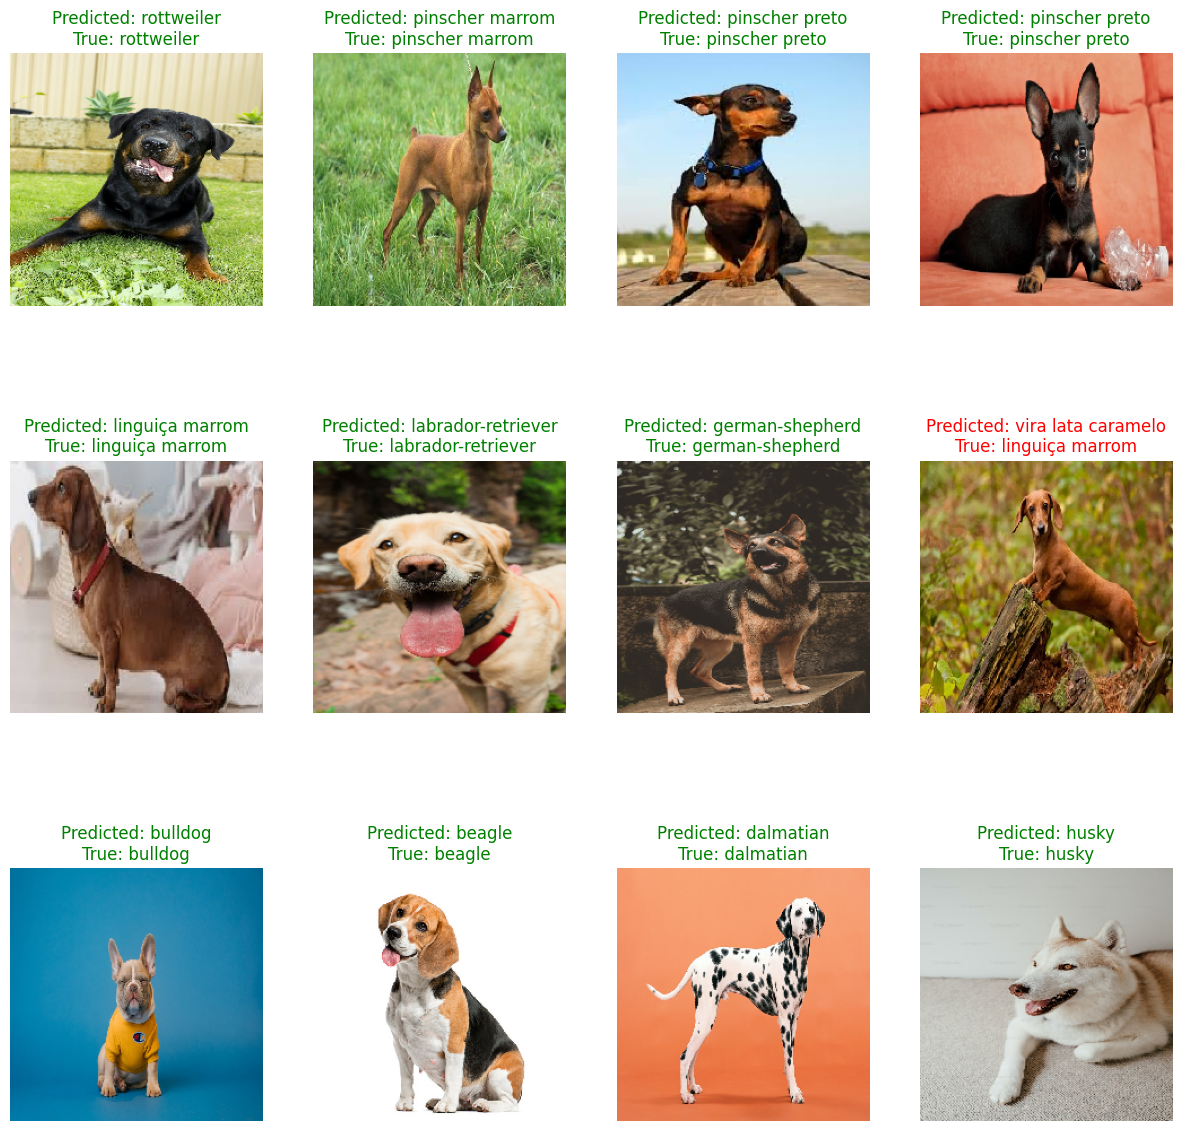

In [14]:
n_rows = 3
n_cols = 4
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(img_height, img_width))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
#plt.show()

In [33]:
#função pra predizer a imagem, só colar dentro da pasta input_image_manual
def image_prediction(image_name_format):
    image_name = str(image_name_format)
    image_local = "input_image_manual/"+image_name
    img_height = 224
    img_width = 224

    img = image.load_img(image_local, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    prediction = model.predict(img_array)

    predicted_labels = np.argmax(prediction, axis=1)
    predicted_labels = [class_names[label] for label in predicted_labels]
    return predicted_labels


In [32]:
image_prediction('5.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


['vira lata preto']